In [29]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Creating the environment

## States

In [30]:
all_states = []
for i in range(20):
    for j in range(20):
        all_states.append((i, j))

## Actions
A stands for attack, D for moving Downward , U for moving Upward and  ... 

In [31]:
actions = ['AD', 'AU', 'AR', 'AL', 'D', 'U', 'R', 'L']

## Foods
We add 8 food sources randomly to our environment

In [32]:
foods = random.sample(all_states, 8)

## Agents
We initialize 4 position for our agents in our environment

In [33]:
remain_states = [x for x in all_states if x not in foods]
agents = random.sample(remain_states, 4)

In [34]:
dict_agent = {}
for i in range(4):
    dict_agent[i] = agents[i]

## Environment

In [35]:
#This function update the environment based on agent's movement
def update_env(foods, agents, all_states=all_states):
    environment = {}
    for i in all_states:
        if i in foods:
            environment[i] = 1
        elif i in agents:
            environment[i] = 2
        else:
            environment[i] = 0
    return environment

In [36]:
#This function update agent postion list
def update_agent_position(new_agent_position, previous_agent_position, agents):
    return [
        new_agent_position if x == previous_agent_position else x
        for x in agents
    ]

## Rewards
it returns rewards and next agent's position

In [37]:
# This funtion returns next coordination of an agent and its reward based on the action
def get_reward_and_position(agent, action, env):
    i, j = agent
    if action.startswith('A'):
        attack_to = action.replace('A', '')

        if attack_to == 'U':
            i -= 1
        if attack_to == 'D':
            i += 1
        if attack_to == 'L':
            j -= 1
        if attack_to == 'R':
            j += 1
        position = (i, j)
        if env.get(position) == 2:
            return position, 2
        return agent, -0.01

    if action == 'U':
        i -= 1
    if action == 'D':
        i += 1
    if action == 'L':
        j -= 1
    if action == 'R':
        j += 1

    if not (i > 19 or i < 0 or j > 19 or j < 0):
        if env[i, j] == 0:
            return (i, j), 0
        elif env[i, j] == 1:
            return agent, 1
    return agent, 0

In [38]:
def get_neighbor_list(agent, arr):
    a, b = agent
    if a < 0:
        a += 20
    lst = []
    for i in range(20):
        for j in range(20):
            if i - 2 < a < i + 2 and j - 2 < b < j + 2:
                if i != a or j != b:
                    lst.append(arr[i, j])
    return str(lst)

# Exploration and Exploitation

In [44]:
def explorAndExploit(initizlize=True,
                     noise=0.2,
                     decreasing_noise=False,
                     explore_iteration=1000,
                     exploit_iteration=100,
                     foods=None):

    if initizlize:
        if not foods:
            foods = random.sample(all_states, 8)
        remain_states = [x for x in all_states if x not in foods]
        agents = random.sample(remain_states, 4)
        iteration = {
            'agent': [],
            'position': [],
            'state': [],
            'action': [],
            'reward': []
        }
        environment = update_env(foods, agents)
        experience_df = pd.DataFrame(iteration)
    dict_agent = {}
    for i in range(4):
        dict_agent[i] = agents[i]

    final_noise = 1

    if decreasing_noise:
        decreasing_noise = explore_iteration // ((1 / noise) + 1)

    cumulative_reward = {0: 0, 1: 0, 2: 0, 3: 0}
    list_rewards = {0: [], 1: [], 2: [], 3: []}

    noise_change = [1]
    for i in tqdm(range(1, explore_iteration + 1)):

        if decreasing_noise:
            if i % decreasing_noise == 0 and final_noise > 0.01:
                final_noise -= noise
                final_noise = float("%.2f" % final_noise)
                noise_change.append(i)

        elif i == explore_iteration - exploit_iteration:
            final_noise = noise

        for i in range(4):
            dict_agent[i] = agents[i]
        update_env(foods, agents)

        for j in random.sample(range(4), 4):
            try:
                agent = dict_agent[j]
                state = get_neighbor_list(agent, environment)
                #### for one step chceck
                age_df = experience_df[experience_df['agent'] == j]   
                a_s_df = age_df[age_df['state'].apply(lambda x: x == state)]
                max_value = max(a_s_df['reward'])
                best_action = a_s_df[a_s_df.reward == max_value].sample(
                    n=1)['action'].values[0]
                #### for 2 step check
#                 if final_noise == 1 :
#                     raise ValueError('Choose Random Action')
#                 best_action = get_best_action_in_2_step(experience_df,
#                                           agents,
#                                           foods,
#                                           j,
#                                           discount=0.9)
                random_actions = actions.copy()
                random_actions.remove(best_action)

                action = np.random.choice(
                    [best_action, random.choice(random_actions)],
                    p=[1 - final_noise, final_noise])

                #handle noise action
                if action != best_action:
                    agent_position, reward = get_reward_and_position(
                        agent, action, environment)
                    state = get_neighbor_list(agent, environment)

                    cumulative_reward[agents.index(agent)] += reward
                    list_rewards[agents.index(agent)].append(reward)

                    iteration['agent'].append(j)
                    iteration['position'].append(agent)
                    iteration['state'].append(state)
                    iteration['action'].append(action)
                    iteration['reward'].append(reward)

                    if reward == 2:
                        cumulative_reward[agents.index(agent_position)] -= 4
                        lst = list_rewards[agents.index(agent_position)]
                        try:
                            lst[-1] -= 4
                        except:
                            pass
                        list_rewards[agents.index(agent_position)] = lst

                        try:
                            index = max([
                                i for i, x in enumerate(iteration['position'])
                                if x == agent_position
                            ])
                            iteration['reward'][index] -= 4
                        except:
                            pass

                    else:

                        agents = update_agent_position(agent_position, agent,
                                                       agents)
                        dict_agent[j] = agent_position

                        environment = update_env(foods, agents)

                    experience_df = pd.DataFrame(iteration)
                    continue
                else:
                    action = best_action

            except Exception:
                #traceback.print_exc()
                action = random.choice(actions)

            agent_position, reward = get_reward_and_position(
                agent, action, environment)

            cumulative_reward[agents.index(agent)] += reward
            list_rewards[agents.index(agent)].append(reward)

            iteration['agent'].append(j)
            iteration['position'].append(agent)
            iteration['state'].append(state)
            iteration['action'].append(action)
            iteration['reward'].append(reward)

            if reward == 2:
                cumulative_reward[agents.index(agent_position)] -= 4
                lst = list_rewards[agents.index(agent_position)]
                lst[-1] -= 4
                list_rewards[agents.index(agent_position)] = lst

                try:
                    index = max([
                        i for i, x in enumerate(iteration['position'])
                        if x == agent_position
                    ])
                    iteration['reward'][index] -= 4
                except:
                    pass
                pass
            else:
                agents = update_agent_position(agent_position, agent, agents)
                dict_agent[j] = agent_position

            experience_df = pd.DataFrame(iteration)

            environment = update_env(foods, agents)
    return list_rewards, noise_change, experience_df

In [40]:
#get best action based on visiting 2 forward step
def get_best_action_in_2_step(df, agents, food, agent_number, discount=0.9):
    environment = update_env(food, agents)
    agent = agents[agent_number]
    state = get_neighbor_list(agent, environment)
    reward = 0
    total_action = {}
    df2 = df[df['agent'] == agent_number]
    df3 = df2[df2['state'].apply(lambda x: x == state)]
    for i in df3['action']:
        agent_position, reward = get_reward_and_position(agent, i, environment)
        if reward != 0:
            for j in df3['action']:
                _, reward2 = get_reward_and_position(agent, j, environment)
                total_action[i, j] = reward + discount * reward2

        else:
            agents = update_agent_position(agent_position, agent, agents)
            environment = update_env(food, agents)
            state2 = get_neighbor_list(agent, environment)
            df4 = df2[df2['state'].apply(lambda x: x == state2)]
            for k in df4['action']:
                _, reward2 = get_reward_and_position(agent, k, environment)
                total_action[i, k] = reward + discount * reward2
    return max(total_action, key=total_action.get)[0]

# Showing plot 

In [41]:
def show_plot(experience_df, noise_change, title=''):
    a0 = np.cumsum(experience_df[experience_df['agent'] == 0]['reward'])
    a1 = np.cumsum(experience_df[experience_df['agent'] == 1]['reward'])
    a2 = np.cumsum(experience_df[experience_df['agent'] == 2]['reward'])
    a3 = np.cumsum(experience_df[experience_df['agent'] == 3]['reward'])

    plt.figure(dpi=120)

    plt.title(title)

    for xc in noise_change:
        plt.axvline(x=xc, color='k', linestyle='--' ,  linewidth=0.3)

    plt.plot(range(len(a0)), a0, label="a0")
    plt.plot(range(len(a0)), a1, label="a1")
    plt.plot(range(len(a0)), a2, label="a2")
    plt.plot(range(len(a0)), a3, label="a3")

    plt.xlabel("Iteration")
    plt.ylabel('Cumulative reward')

    plt.legend()
    plt.show()

# Samples

## 2000 iteration

### Done with check 1 forward step

100%|██████████| 2000/2000 [00:29<00:00, 66.73it/s]


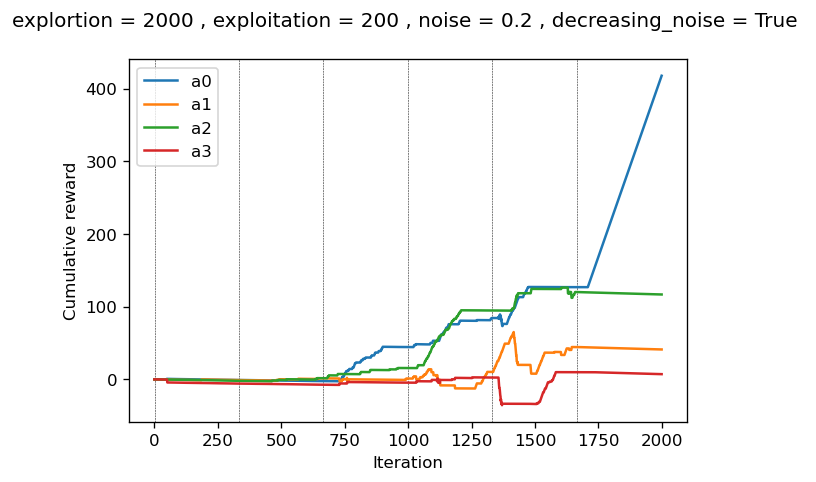

100%|██████████| 2000/2000 [00:30<00:00, 66.03it/s]


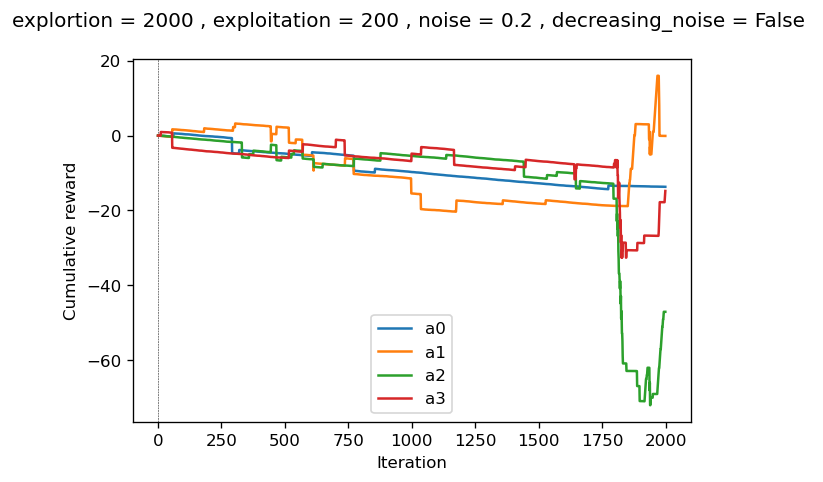

100%|██████████| 2000/2000 [00:31<00:00, 64.31it/s]


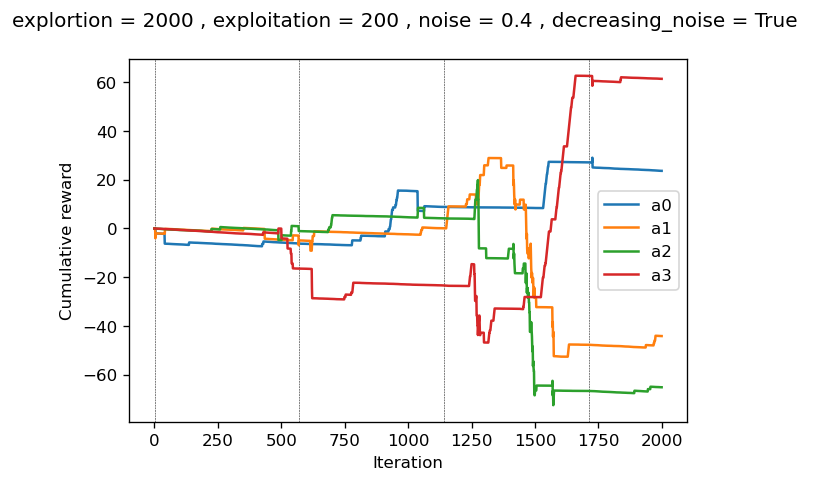

100%|██████████| 2000/2000 [00:30<00:00, 65.66it/s]


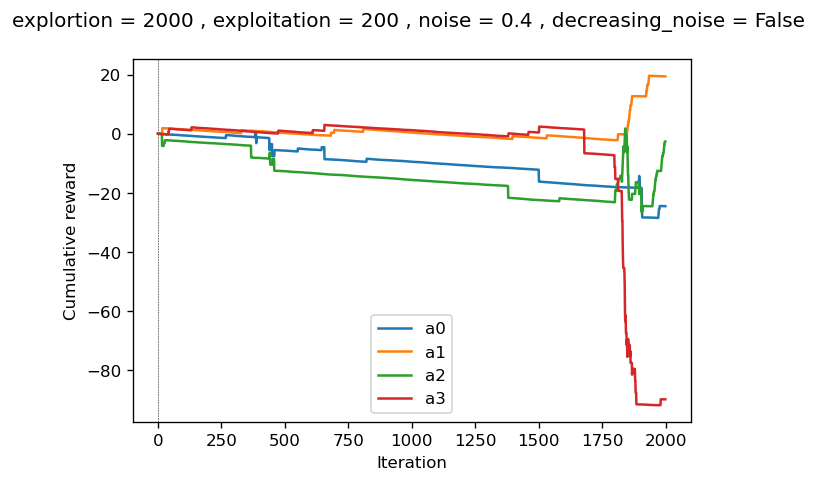

100%|██████████| 2000/2000 [00:30<00:00, 65.74it/s]


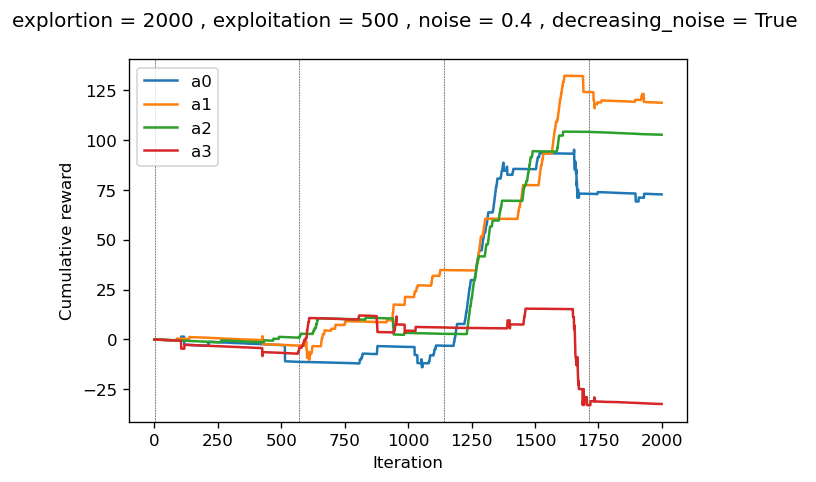

100%|██████████| 2000/2000 [00:30<00:00, 65.62it/s]


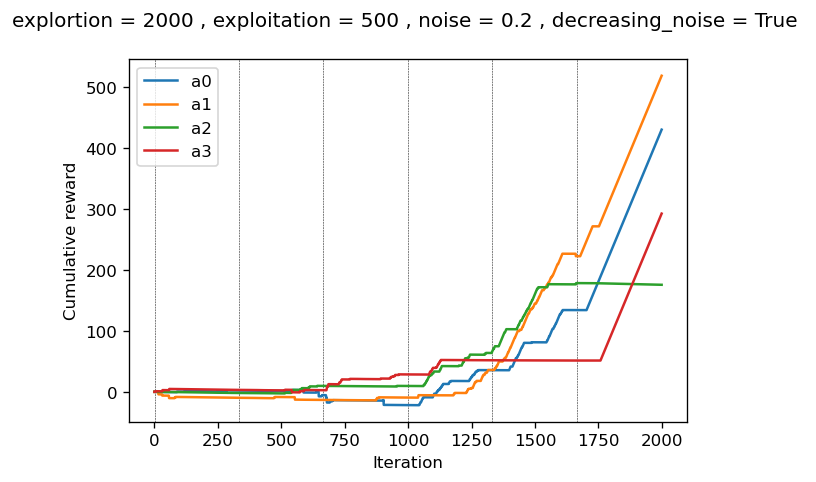

In [ ]:
list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.2,
    explore_iteration=2000,
    exploit_iteration=200,
    foods=foods)

show_plot(experience_df, noise_change,
          'explortion = 2000 , exploitation = 200 , noise = 0.2 , decreasing_noise = True \n')

list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=False,
    noise=0.2,
    explore_iteration=2000,
    exploit_iteration=200,
    foods=foods)

show_plot(experience_df, noise_change,
          'explortion = 2000 , exploitation = 200 , noise = 0.2 , decreasing_noise = False \n')


list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.4,
    explore_iteration=2000,
    exploit_iteration=200,
    foods=foods)

show_plot(experience_df, noise_change,
          'explortion = 2000 , exploitation = 200 , noise = 0.4 , decreasing_noise = True \n')

list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=False,
    noise=0.4,
    explore_iteration=2000,
    exploit_iteration=200,
    foods=foods)

show_plot(experience_df, noise_change,
          'explortion = 2000 , exploitation = 200 , noise = 0.4 , decreasing_noise = False \n')

list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.4,
    explore_iteration=2000,
    exploit_iteration=500,
    foods=foods)

show_plot(experience_df, noise_change,
          'explortion = 2000 , exploitation = 500 , noise = 0.4 , decreasing_noise = True \n')

list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.2,
    explore_iteration=2000,
    exploit_iteration=500,
    foods=foods)

show_plot(experience_df, noise_change,
          'explortion = 2000 , exploitation = 500 , noise = 0.2 , decreasing_noise = True \n')

### Done with check 2 forward step

100%|██████████| 2000/2000 [08:14<00:00,  4.04it/s] 


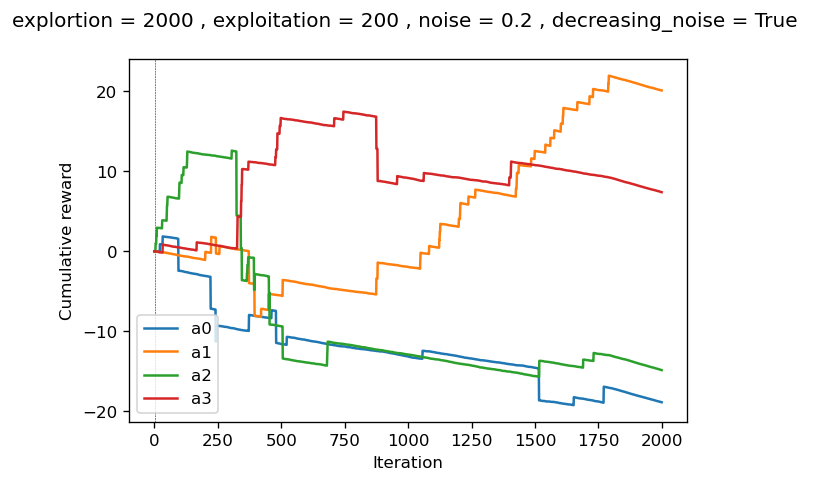

In [69]:
#Done with 2 forward step checking
list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=False,
    noise=0.2,
    explore_iteration=2000,
    exploit_iteration=200,
    foods=foods)

show_plot(experience_df, noise_change,
          'explortion = 2000 , exploitation = 200 , noise = 0.2 , decreasing_noise = True \n')

## 5000 iteration

100%|██████████| 5000/5000 [02:26<00:00, 34.12it/s]


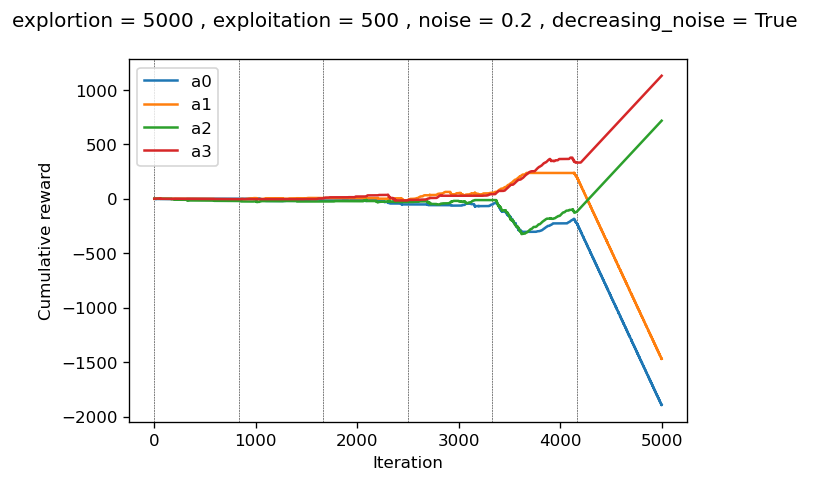

100%|██████████| 5000/5000 [02:23<00:00, 34.88it/s]


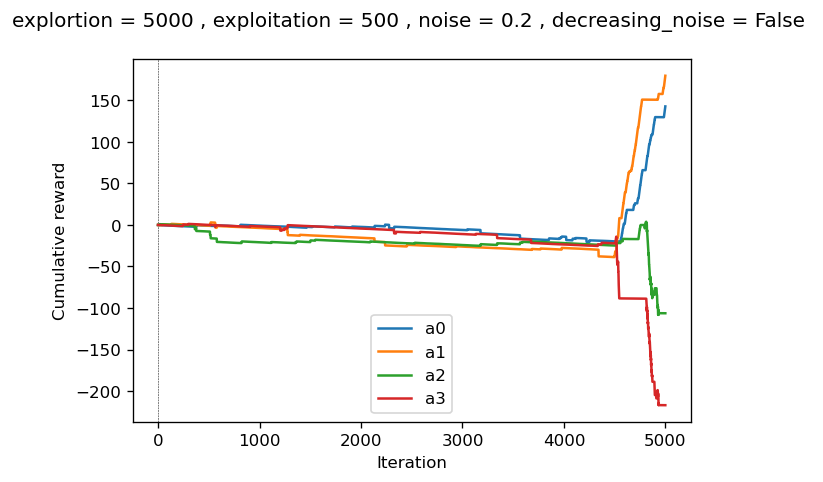

100%|██████████| 5000/5000 [02:24<00:00, 34.50it/s]


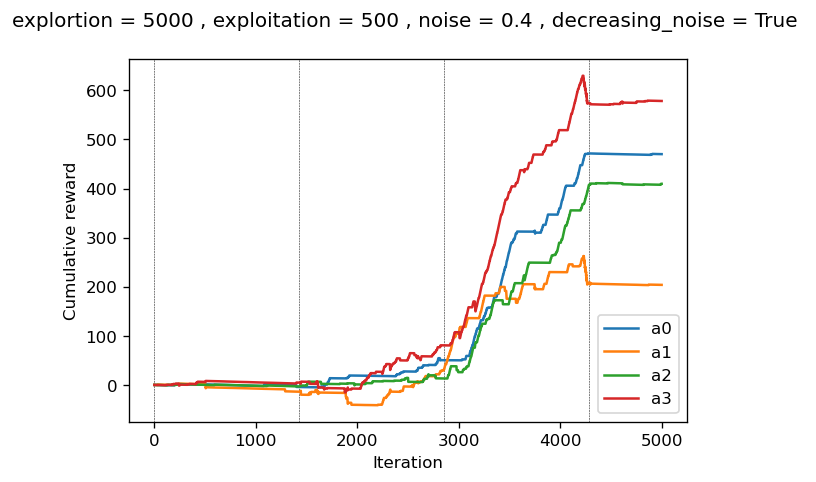

100%|██████████| 5000/5000 [02:23<00:00, 34.86it/s]


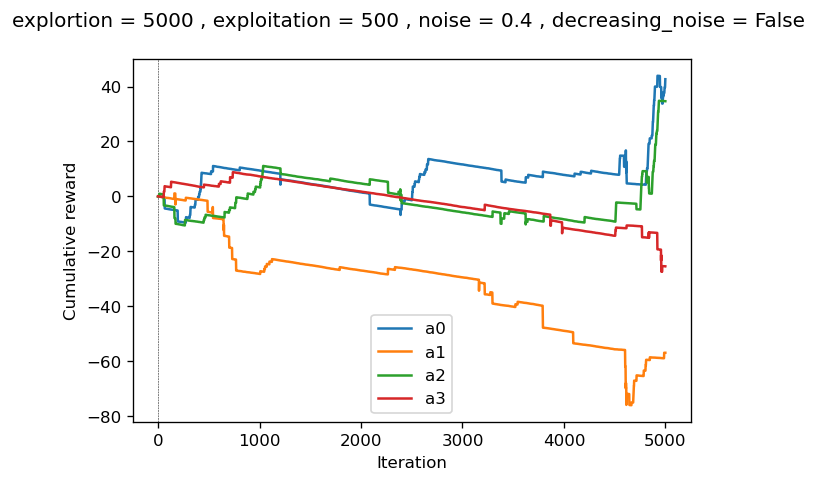

100%|██████████| 5000/5000 [02:24<00:00, 34.61it/s]


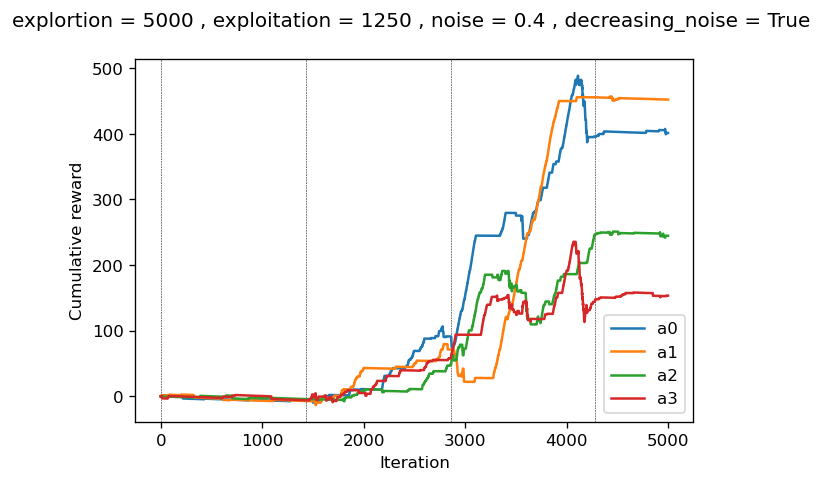

100%|██████████| 5000/5000 [02:25<00:00, 34.26it/s]


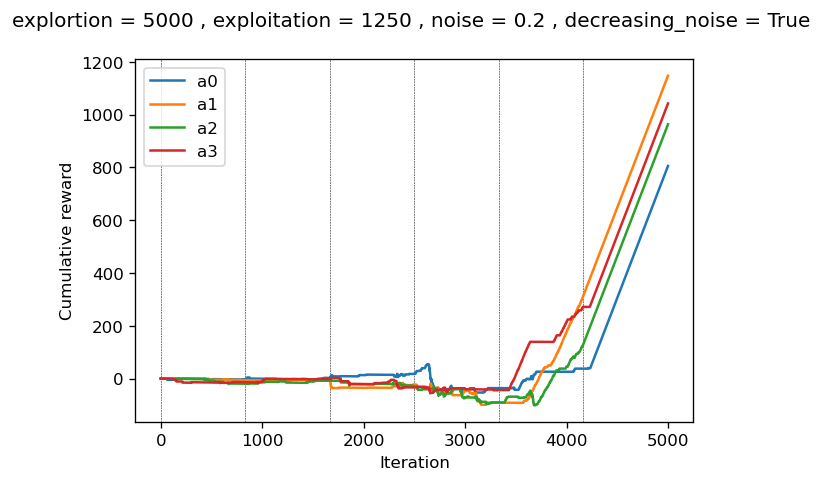

In [ ]:
list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.2,
    explore_iteration=5000,
    exploit_iteration=500)

show_plot(experience_df, noise_change,
          'explortion = 5000 , exploitation = 500 , noise = 0.2 , decreasing_noise = True \n')

list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=False,
    noise=0.2,
    explore_iteration=5000,
    exploit_iteration=500)

show_plot(experience_df, noise_change,
          'explortion = 5000 , exploitation = 500 , noise = 0.2 , decreasing_noise = False \n')

list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.4,
    explore_iteration=5000,
    exploit_iteration=500)

show_plot(experience_df, noise_change,
          'explortion = 5000 , exploitation = 500 , noise = 0.4 , decreasing_noise = True \n')

list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=False,
    noise=0.4,
    explore_iteration=5000,
    exploit_iteration=500)

show_plot(experience_df, noise_change,
          'explortion = 5000 , exploitation = 500 , noise = 0.4 , decreasing_noise = False \n')

list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.4,
    explore_iteration=5000,
    exploit_iteration=1250)

show_plot(experience_df, noise_change,
          'explortion = 5000 , exploitation = 1250 , noise = 0.4 , decreasing_noise = True \n')

list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.2,
    explore_iteration=5000,
    exploit_iteration=1250)

show_plot(experience_df, noise_change,
          'explortion = 5000 , exploitation = 1250 , noise = 0.2 , decreasing_noise = True \n')

## 10000 iteration

100%|██████████| 10000/10000 [08:55<00:00, 18.68it/s]


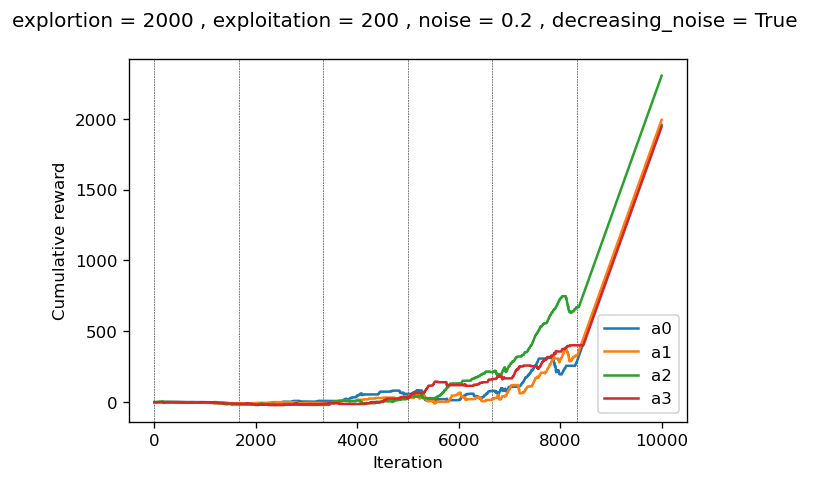

In [77]:
list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.2,
    explore_iteration=10000,
    exploit_iteration=200,
    foods=foods)

show_plot(experience_df, noise_change,
          'explortion = 2000 , exploitation = 200 , noise = 0.2 , decreasing_noise = True \n')

## 20000 iteration

100%|██████████| 20000/20000 [35:37<00:00,  9.36it/s]


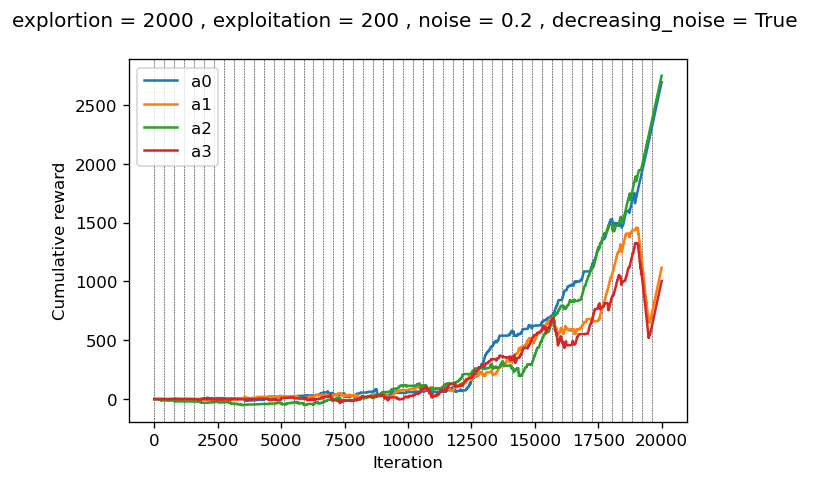

In [28]:
list_rewards, noise_change, experience_df = explorAndExploit(
    decreasing_noise=True,
    noise=0.02,
    explore_iteration=20000,
    exploit_iteration=500,
    foods=foods)

show_plot(experience_df, noise_change,
          'explortion = 2000 , exploitation = 200 , noise = 0.2 , decreasing_noise = True \n')

In [31]:
experience_df.to_csv('ai20000.csv' , index=None)